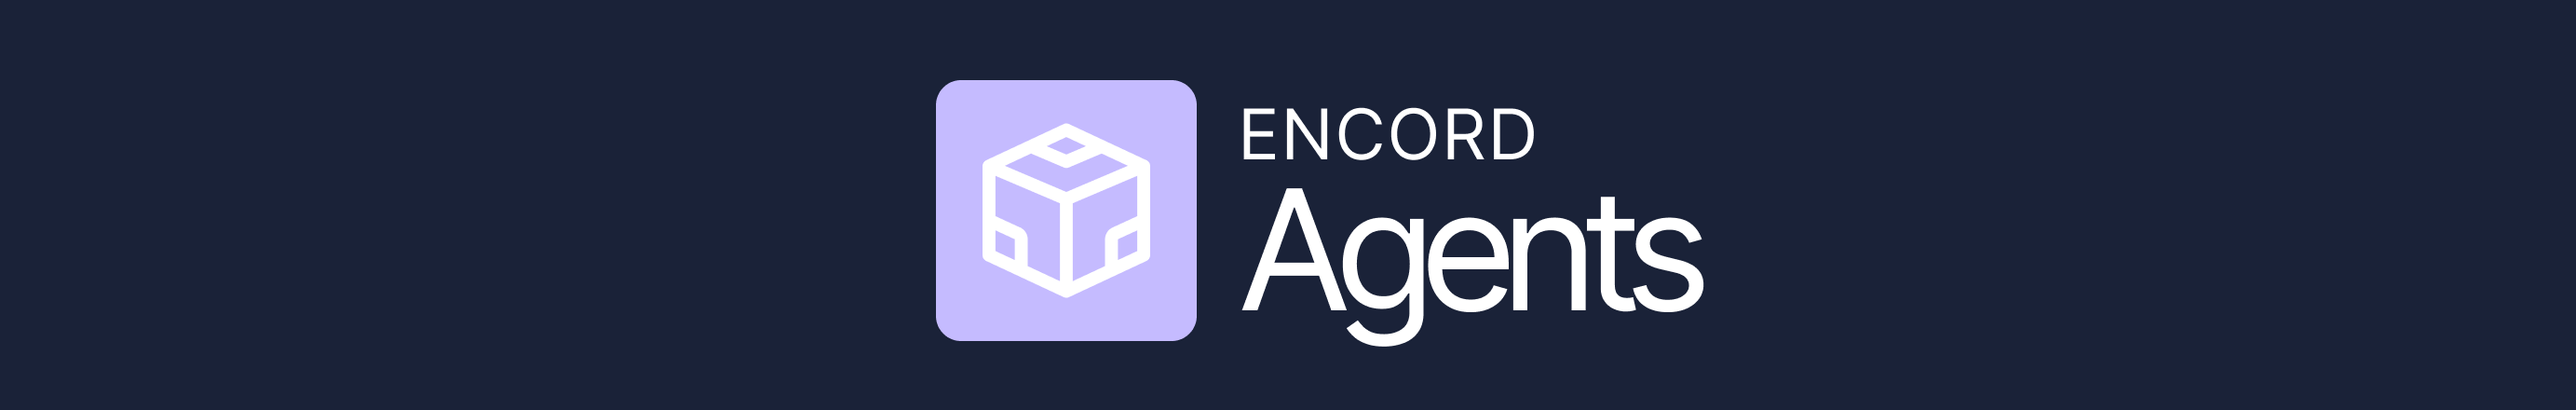


# Transferring labels to a twin project

This example demonstrates how to transfer checklist labels from "Project A" and convert them into yes/no radio labels in "Project B."

## Prerequisites

In order to follow this example, you will need to have two project with ontologies and workflows following a specific template.

> **Note:** Both Project A and Project B must be linked to the same datasets.



### Ontologies
[📖 here](https://docs.encord.com/platform-documentation/GettingStarted/gettingstarted-create-ontology) is the documentation for creating ontologies.

- **Ontology in Project A:**  
  The Ontology in Project A contains checklist classifications, as shown below:



<figure>
  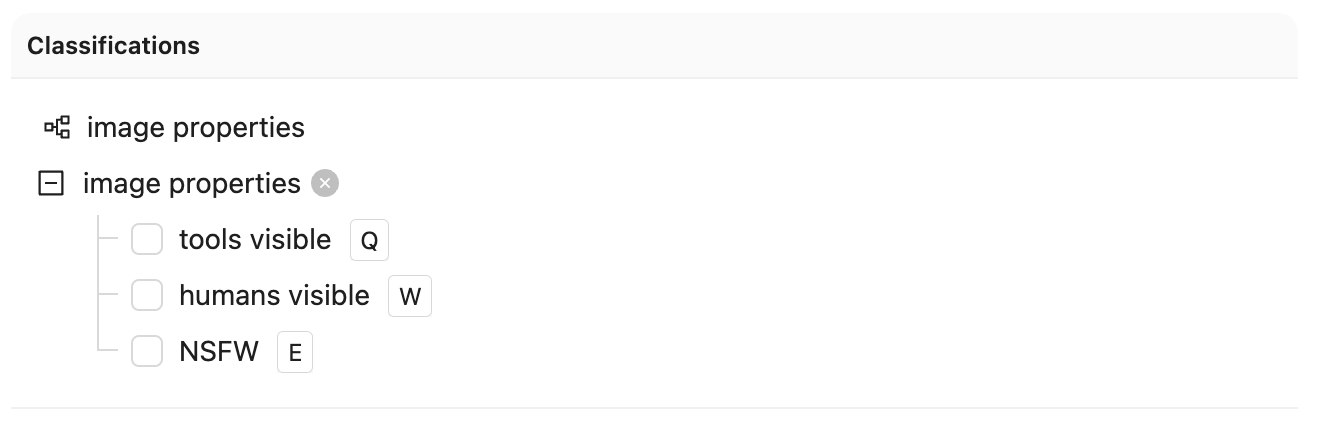
  <figcaption><strong>Figure 1:</strong> Source project ontology (Project A).
</figure>

- **Ontology in Project B:**  
  Every completed task in Project A is translated into a "model-friendly version" with radio classifications in Project B:



<figure>
  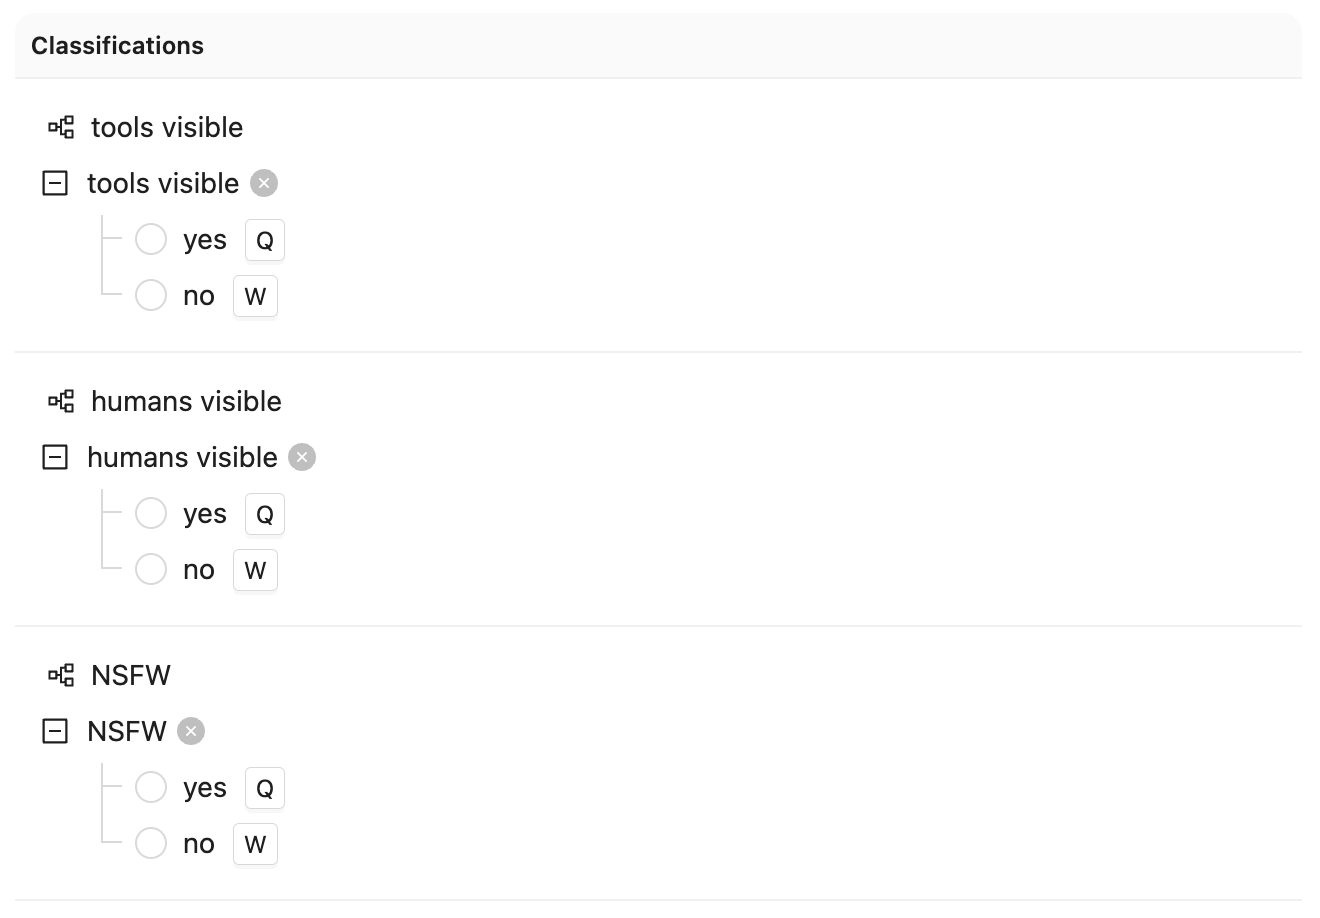
  <figcaption><strong>Figure 2:</strong> Sink project ontology (Project B).
</figure>



> Notice that Project B has three classifications with identical names to those in Project A, but with two radio options each.



### Workflows

The following are examples of Workflows to be used. Create and save a Workflow template for each workflow.

[📖 here](https://docs.encord.com/platform-documentation/Annotate/annotate-projects/annotate-workflows-and-templates#creating-workflows) is the documentation for creating a workflow with Encord.

- **Project A Workflow:**

<figure style="text-align: center">
  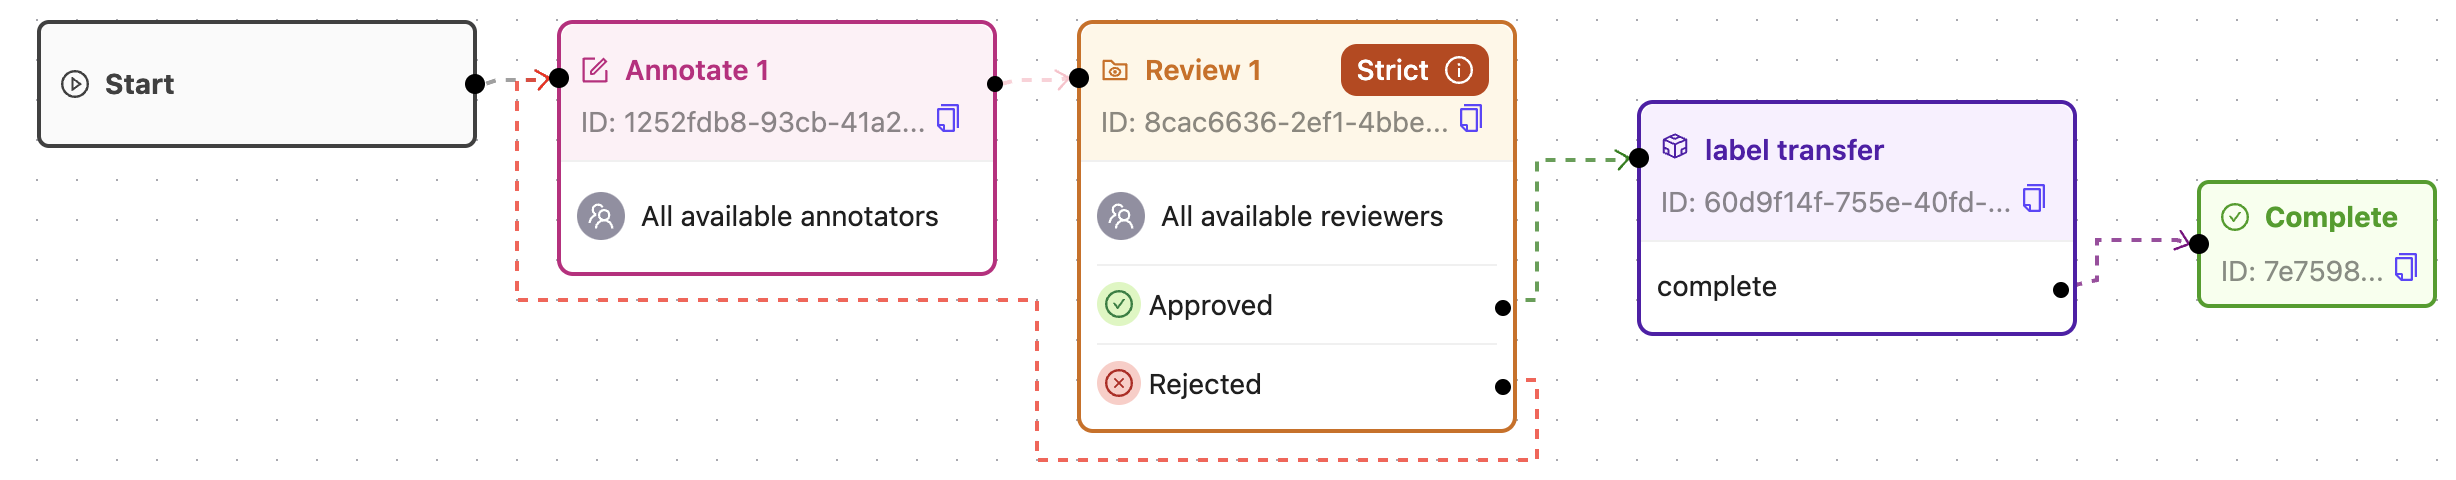
  <figcaption><strong>Figure 3:</strong> Project A Workflow</figcaption>
</figure>


- **Project B Workflow:**


<figure style="text-align: center">
  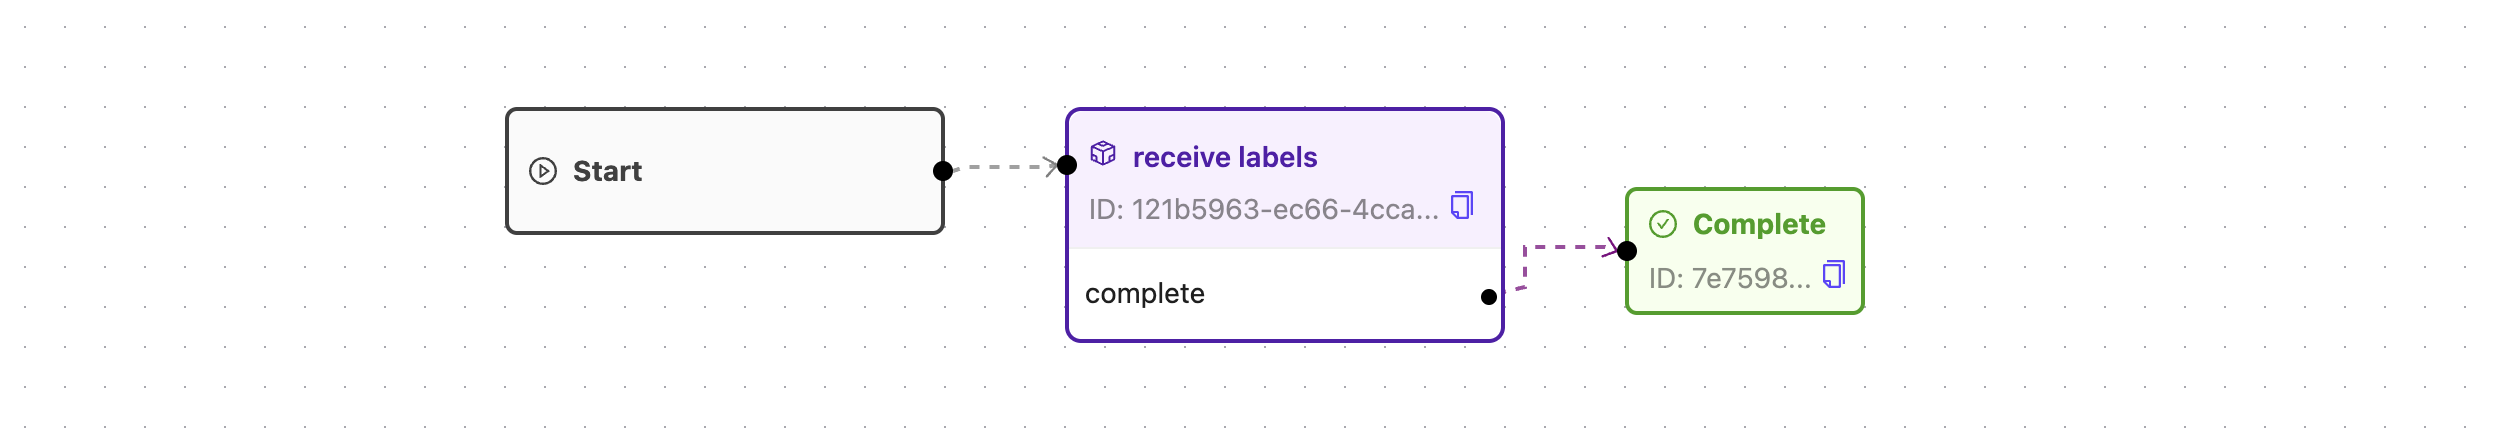
  <figcaption><strong>Figure 4:</strong> Project B Workflow</figcaption>
</figure>


With this configuration, all annotation work happens in Project A, while Project B mirrors the transformed labels.

### Installation

Please ensure that you have the `encord-agents` library installed:

In [ ]:
!python -m pip install encord-agents

### Authentication

The library authenticates via ssh-keys. Below, is a code cell for setting the `ENCORD_SSH_KEY` environment variable. It should contain the raw content of your private ssh key file.

If you have not yet setup an ssh key, please follow the [documentation](https://agents-docs.encord.com/authentication/).

> 💡 **Colab users**: In colab, you can set the key once in the secrets in the left sidebar and load it in new notebooks with
> ```python
> from google.colab import userdata
> key_content = userdata.get("ENCORD_SSH_KEY")
> ```

In [ ]:
import os

os.environ["ENCORD_SSH_KEY"] = "private_key_file_content"
# or you can set a path to a file
# os.environ["ENCORD_SSH_KEY_FILE"] = "/path/to/your/private/key"

#### [Alternative] Temporary Key
There's also the option of generating a temporary (fresh) ssh key pair via the code cell below.
Please follow the instructions printed when executing the code.

In [ ]:
# ⚠️ Safe to skip if you have authenticated already
import os

from encord_agents.utils.colab import generate_public_private_key_pair_with_instructions

private_key_path, public_key_path = generate_public_private_key_pair_with_instructions()
os.environ["ENCORD_SSH_KEY_FILE"] = private_key_path.as_posix()

## Agent definition

An agent can perform this translation using the [`dep_twin_label_row` dependency](../../reference/task_agents.md#encord_agents.tasks.dependencies.dep_twin_label_row). For every label row from Project A, the agent automatically fetches the corresponding label row (and optionally the Workflow task) from Project B.

Below is a template for doing the translation.


You will have to fill in the following pieces of information to wire things together:
- `<project_hash_a>`: The project hash for Project A
- `<project_hash_b>`: The project hash for Project B
- `<transfer_agent_stage_uuid>`: The task agent node uuid in Project A.
- `<labeling_completion_pathway_uuid>`: The uuid (or name) of the pathway in Project A that leads to the complete state.
- `<twin_completion_pathway_uuid>`: The uuid (or name) of the pathway in Project B that leads to the complete state.


In [ ]:
from encord.objects.ontology_labels_impl import LabelRowV2
from encord.objects.options import Option
from encord.workflow.stages.agent import AgentTask
from typing_extensions import Annotated

from encord_agents.tasks import Depends, Runner
from encord_agents.tasks.dependencies import Twin, dep_twin_label_row

# 1. Setup the runner
runner = Runner(project_hash="<project_hash_a>")

# 2. Get the classification attribute used to query answers
checklist_classification = runner.project.ontology_structure.classifications[0]  # type: ignore
checklist_attribute = checklist_classification.attributes[0]


# 3. Define the agent
@runner.stage(stage="<transfer_agent_stage_uuid>")
def copy_labels(
    manually_annotated_lr: LabelRowV2,
    twin: Annotated[Twin, Depends(dep_twin_label_row(twin_project_hash="<project_hash_b>"))],
) -> str | None:
    # 4. Reading the checkboxes that have been set
    instance = manually_annotated_lr.get_classification_instances()[0]
    answers = instance.get_answer(attribute=checklist_attribute)
    if answers is None or isinstance(answers, (str, Option)):
        return None

    set_options = {o.title for o in answers}  # Use title to match

    # 5. Set answer on the sink labels
    for radio_clf in twin.label_row.ontology_structure.classifications:
        ins = radio_clf.create_instance()

        attr = radio_clf.attributes[0]
        if radio_clf.title in set_options:
            ins.set_answer(attr.options[0])
        else:
            ins.set_answer(attr.options[1])

        ins.set_for_frames(frames=0)
        twin.label_row.add_classification_instance(ins)

    # 6. Save labels and proceed tasks
    twin.label_row.save()
    if twin.task and isinstance(twin.task, AgentTask):
        twin.task.proceed(pathway_uuid="<twin_completion_pathway_uuid>")

    return "<labeling_completion_pathway_uuid>"

The code does six things:

1. Instantiates a runner which will execute the agent code against every task in the agent stage of the project
2. Read the necessary information to do the label translation from the ontology of Project A
3. Links the implementation to the correct stage in project A + define a `twin_label_dependency` to the twin project in order to be able to write the converted labels to the other project
4. Reads the manual annotations
5. Converts and writes the labels to Project B
6. Proceeds the two "sibling tasks" from Project A and B to the complete state


## Running the agent
Now that we've defined the projects, workflows, and the agent, it's time to try it out.
The `runner` object is callable which means that you can just call it to prioritize your tasks.

In [ ]:
# Run the agent
runner()

Once the agent is running, tasks approved in Project A’s review stage move to the "Complete" stage in Project B, with the labels automatically converted and displayed.

> 💡*Hint:* If you were to execute this as a python script, you can run it as a command line interface by putting the above code in an `agents.py` file and replacing
> ```python
> runner()
> ```
> with
> ```python
> if __name__ == "__main__":
>     runner.run()
> ```
> Which will allow you set, e.g., the project hash via the command line:
> ```bash
> python agent.py --project-hash "..."
> ```
